<a href="https://colab.research.google.com/github/danicardonaibz/molecular_equilibrium/blob/main/ML_Material_Science_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive

from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.utils import plot_model

In [7]:
# Setting seaborn plotting context
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

In [8]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
data_path = '/content/drive/MyDrive/m1507656/data_clean.npz'

# Step 1: Create a TensorFlow dataset

This will be done first creating a fast input pipeline and then applying consecutive lambda functions to complete de data load

In [10]:
!nvidia-smi

Mon Nov 28 20:06:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   28C    P0    42W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
columns = ['xyz_pbe_relaxed',
 'tpsa',
 'mol_w',
 'num_valence_electrons',
 'num_heteroatoms',
 'number_of_atoms',
 'mol2vec',
 'total_energy_pbe']

In [12]:
# Loading the data
with np.load(data_path, allow_pickle = True) as data:
  
  X_train_molecules = tf.data.Dataset.from_tensor_slices(data['X_train'][:, 1:5].astype(np.float32))
  X_train_smiles = tf.data.Dataset.from_tensor_slices(data['X_train'][:, -1].tolist())
  X_train_locations = tf.data.Dataset.from_tensor_slices(data['X_train'][:, 0].tolist())
  X_test_molecules = tf.data.Dataset.from_tensor_slices(data['X_test'][:, 1:5].astype(np.float32))
  X_test_smiles = tf.data.Dataset.from_tensor_slices(data['X_test'][:, -1].tolist())
  X_test_locations = tf.data.Dataset.from_tensor_slices(data['X_test'][:, 0].tolist())

  y_train = tf.data.Dataset.from_tensor_slices(data['y_train'].astype(np.float32))
  y_test = tf.data.Dataset.from_tensor_slices(data['y_test'].astype(np.float32))

In [13]:
# Making TensorFlow datasets
train_dataset_molecules = tf.data.Dataset.zip((X_train_molecules, y_train))
train_dataset_locations = tf.data.Dataset.zip((X_train_locations, y_train))
train_dataset_smiles = tf.data.Dataset.zip((X_train_smiles, y_train))

test_dataset_molecules = tf.data.Dataset.zip((X_test_molecules, y_test))
test_dataset_locations = tf.data.Dataset.zip((X_test_locations, y_test))
test_dataset_smiles = tf.data.Dataset.zip((X_test_smiles, y_test))

In [14]:
# Getting dataset length
dataset_length = len(X_train_molecules)

# Step 2: DL models

In [15]:
tf.random.set_seed(42)

## Model 0: Molecular parameter model
Baseline with molecule parameters only

In [16]:
# Batch and prefetch for optimal performance
BATCH_SIZE = 1024  # 1024 molecules evaluated at the same time

train_dataset_molecules = train_dataset_molecules.cache().shuffle(dataset_length).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset_molecules = test_dataset_molecules.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
train_dataset_molecules, test_dataset_molecules

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>)

In [17]:
# Get some insights form the input data before starting with our experiments
for feature, _ in train_dataset_molecules.unbatch().take(1):
  input_shape = feature.shape
  print(f"Input shape is: {input_shape} and looks like {feature}.")

Input shape is: (4,) and looks like [ 53.99    280.13107 110.        5.     ].


In [18]:
# Normalization layer for parameters, along 1 axis (columns)
norm_layer_molecules = tf.keras.layers.Normalization(name = 'normalization_molecules')  # Axis = -1

norm_layer_molecules.adapt(data = train_dataset_molecules.map(
    map_func = lambda features, energy: features,
    num_parallel_calls = tf.data.AUTOTUNE
))

In [19]:
# Testing normalization layer and getting input shape
#for _, (X, y) in enumerate(.take(1)):
#  test_x = X
#  input_shape = X.shape
#test_x, norm_layer(test_x)

In [20]:
inputs = tf.keras.layers.Input(shape = input_shape, name = "input_layer")
x = norm_layer_molecules(inputs)
x = tf.keras.layers.Dense(units = 128)(x)
output = tf.keras.layers.Dense(units = 1,
                              name = 'output_layer')(x)
model_0 = tf.keras.Model(inputs = inputs,
                         outputs = output,
                         name = 'model_0')

In [21]:
# Compiling the model
model_0.compile(loss = tf.keras.losses.mae,
                optimizer = tf.keras.optimizers.Adam(),
                metrics = tf.keras.metrics.mae)

In [22]:
model_0.summary(show_trainable = True)

Model: "model_0"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_layer (InputLayer)    [(None, 4)]               0         Y          
                                                                            
 normalization_molecules (No  (None, 4)                9         Y          
 rmalization)                                                               
                                                                            
 dense (Dense)               (None, 128)               640       Y          
                                                                            
 output_layer (Dense)        (None, 1)                 129       Y          
                                                                            
Total params: 778
Trainable params: 769
Non-trainable params: 9
________________________________________________________________________

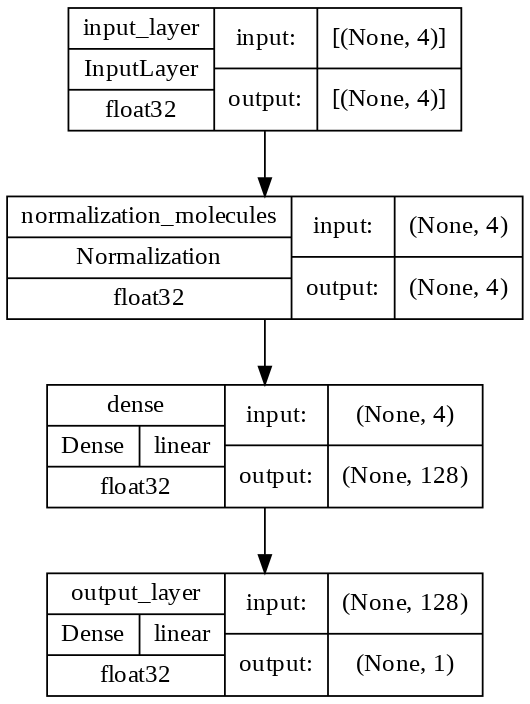

In [23]:
# Plot model 0
plot_model(model_0,
           to_file="model0.png",
           show_shapes = True,
           show_dtype = True,
           dpi = 128,
           show_layer_activations = True
           )

In [24]:
# Fit the model
history_0 = model_0.fit(train_dataset_molecules,
            epochs = 5000,
            validation_data = test_dataset_molecules,
            callbacks = [tf.keras.callbacks.EarlyStopping(
                patience = 40,
                monitor = 'val_loss',
                restore_best_weights = True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                patience = 10,
                monitor = 'val_loss',
                verbose = 1
            )])

Epoch 1/5000
43/43 [==============================] - 3s 6ms/step - loss: 46222.5039 - mean_absolute_error: 46222.5039 - val_loss: 45928.0859 - val_mean_absolute_error: 45928.0859 - lr: 0.0010
Epoch 2/5000
43/43 [==============================] - 0s 3ms/step - loss: 46221.2344 - mean_absolute_error: 46221.2344 - val_loss: 45926.3047 - val_mean_absolute_error: 45926.3047 - lr: 0.0010
Epoch 3/5000
43/43 [==============================] - 0s 3ms/step - loss: 46218.9062 - mean_absolute_error: 46218.9062 - val_loss: 45923.3672 - val_mean_absolute_error: 45923.3672 - lr: 0.0010
Epoch 4/5000
43/43 [==============================] - 0s 3ms/step - loss: 46215.3750 - mean_absolute_error: 46215.3750 - val_loss: 45919.1758 - val_mean_absolute_error: 45919.1758 - lr: 0.0010
Epoch 5/5000
43/43 [==============================] - 0s 3ms/step - loss: 46210.5547 - mean_absolute_error: 46210.5547 - val_loss: 45913.7188 - val_mean_absolute_error: 45913.7188 - lr: 0.0010
Epoch 6/5000
43/43 [===============

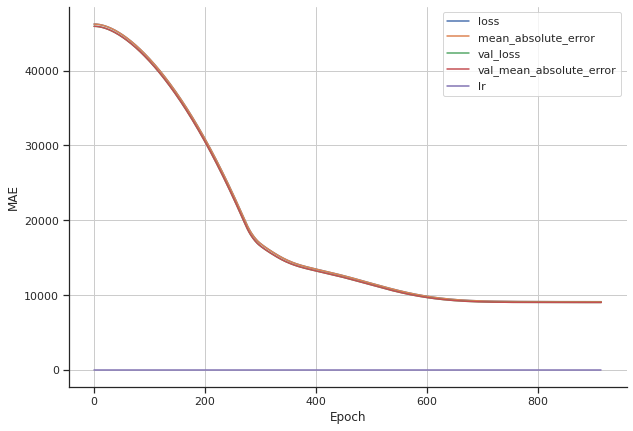

In [25]:
# Viewing training history
# Viewing training history
fig, ax = plt.subplots(figsize=(10,7))
pd.DataFrame(history_0.history).plot(ax = ax)
ax.grid(True)
ax.set_ylabel('MAE');
ax.set_xlabel('Epoch');
plt.savefig('history_0.png', dpi = 600, bbox_inches = 'tight')
plt.show()

In [26]:
# Evaluate model 0 on test data
results_0 = model_0.evaluate(test_dataset_molecules)
results_0

15/15 [==============================] - 0s 2ms/step - loss: 9025.4746 - mean_absolute_error: 9025.4746


[9025.474609375, 9025.474609375]

## Model 1: Positional model
The analysis is going to be performed with a CNN network, feeding xyz positions described with the Coulomb matrix

In [27]:
# Batch and prefetch for optimal performance
BATCH_SIZE = 1024

train_dataset_locations = train_dataset_locations.cache().shuffle(dataset_length).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset_locations = test_dataset_locations.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
train_dataset_locations, test_dataset_locations

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 77, 77), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 77, 77), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>)

In [28]:
# Normalizing Coulomb matrix
norm_layer_coulomb = tf.keras.layers.Normalization(name = 'normalization_coulomb')

norm_layer_coulomb.adapt(data = train_dataset_locations.map(
    map_func = lambda coulomb, energy: tf.expand_dims(coulomb, axis = -1),
    num_parallel_calls = tf.data.AUTOTUNE
))

In [29]:
# Model input shape
for feature, _ in train_dataset_locations.unbatch().take(1):
  input_shape_coulomb = feature.shape
  print(f"Model input shape is: {input_shape_coulomb} and looks like {feature}.")

Model input shape is: (77, 77) and looks like [[53.3587074  10.98020352 20.80984052 ...  0.          0.
   0.        ]
 [10.98020352 53.3587074   8.09305608 ...  0.          0.
   0.        ]
 [20.80984052  8.09305608 53.3587074  ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]].


CNNs require an input shape that looks like (batch size, height, width, depth). In order for our data to look like that, a dim expansion on the last axis is necessary, as the current shape is (77,77)

In [30]:
# Embedding dimension expansion on a keras layer
class expand_dims(tf.keras.layers.Layer):
  def __init__(self,
               **kwargs):
    super().__init__(**kwargs)

  def build(self, input_shape):
    print(f"input_shape to expand_dims layer is {input_shape}")
  
  def call(self, inputs, training = None):
      inputs = tf.expand_dims(inputs, axis = -1)
      return inputs

In [31]:
# Testing the layer
for feature, _ in train_dataset_locations.unbatch().take(1):
  output = expand_dims()(feature)
  output_expand_shape = output.shape
  print(f"Input looks like {feature}, output shape is: {output_expand_shape} and looks like {output}.")

input_shape to expand_dims layer is (77, 77)
Input looks like [[73.51669472 14.55822657 23.43855013 ...  0.          0.
   0.        ]
 [14.55822657 73.51669472 23.95470211 ...  0.          0.
   0.        ]
 [23.43855013 23.95470211 53.3587074  ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]], output shape is: (77, 77, 1) and looks like [[[73.51669 ]
  [14.558227]
  [23.43855 ]
  ...
  [ 0.      ]
  [ 0.      ]
  [ 0.      ]]

 [[14.558227]
  [73.51669 ]
  [23.954702]
  ...
  [ 0.      ]
  [ 0.      ]
  [ 0.      ]]

 [[23.43855 ]
  [23.954702]
  [53.358707]
  ...
  [ 0.      ]
  [ 0.      ]
  [ 0.      ]]

 ...

 [[ 0.      ]
  [ 0.      ]
  [ 0.      ]
  ...
  [ 0.      ]
  [ 0.      ]
  [ 0.      ]]

 [[ 0.      ]
  [ 0.      ]
  [ 0.      ]
  ...
  [ 0.      ]
  [ 0.      ]

In [32]:
inputs = tf.keras.layers.Input(shape = input_shape_coulomb, name = "input_layer")
x = expand_dims()(inputs)
x = norm_layer_coulomb(x)
x = tf.keras.layers.Conv2D(filters = 32,
                           kernel_size = 3,
                           activation = 'relu',
                           name = 'convolutional_1')(x)
x = tf.keras.layers.MaxPool2D(name = 'max_pool_1')(x)
x = tf.keras.layers.Dropout(0.25, name = 'first_dropout')(x)
x = tf.keras.layers.Flatten(name = 'flatten_layer')(x)
x = tf.keras.layers.Dense(units = 128)(x)
x = tf.keras.layers.Dropout(0.5, name = 'second_dropout')(x)
output = tf.keras.layers.Dense(units = 1,
                               name = 'output_layer')(x)
model_1 = tf.keras.Model(inputs = inputs,
                         outputs = output,
                         name = 'model_1')

input_shape to expand_dims layer is (None, 77, 77)


In [33]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 77, 77)]          0         
                                                                 
 expand_dims_1 (expand_dims)  (None, 77, 77, 1)        0         
                                                                 
 normalization_coulomb (Norm  (None, 77, 77, 1)        3         
 alization)                                                      
                                                                 
 convolutional_1 (Conv2D)    (None, 75, 75, 32)        320       
                                                                 
 max_pool_1 (MaxPooling2D)   (None, 37, 37, 32)        0         
                                                                 
 first_dropout (Dropout)     (None, 37, 37, 32)        0         
                                                           

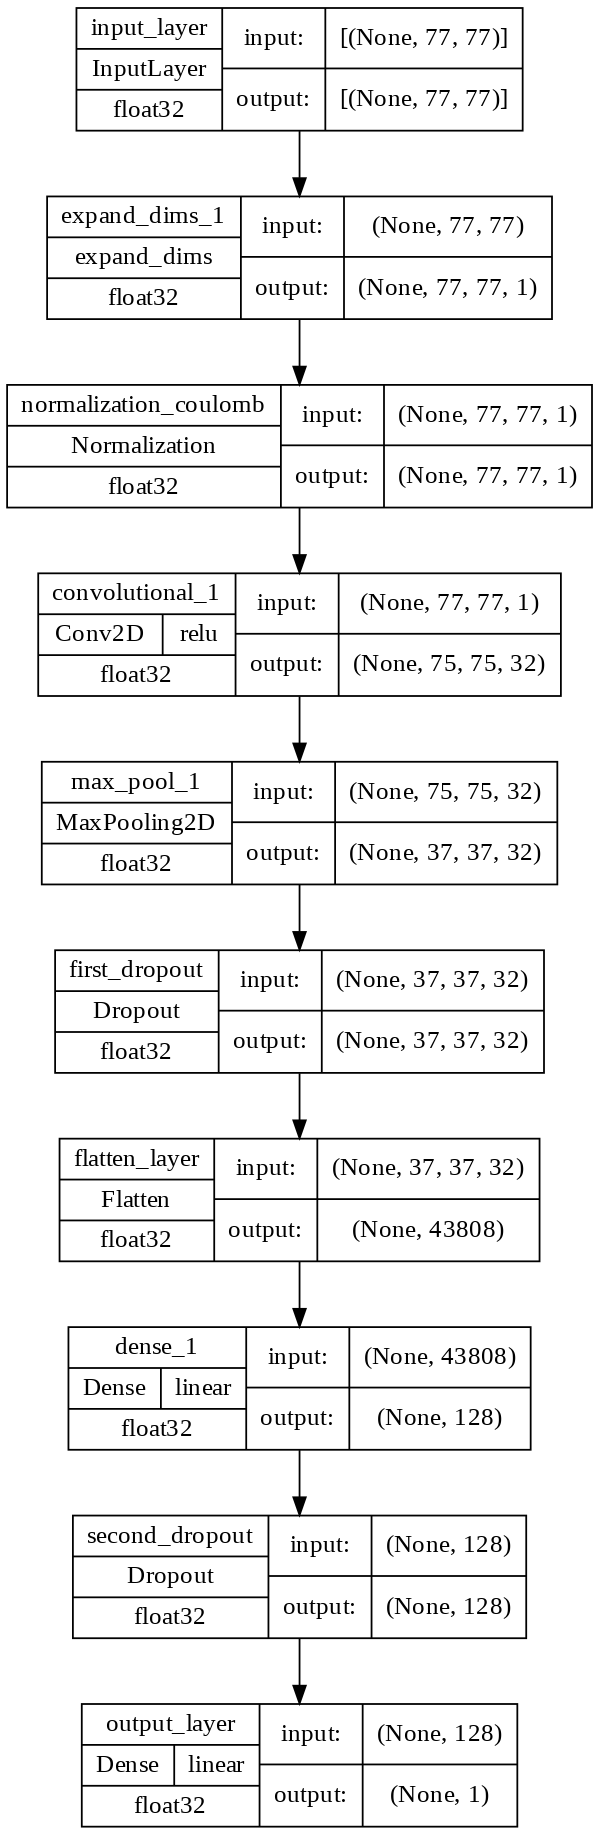

In [34]:
# Plot model 1
plot_model(model_1,
           to_file="model1.png",
           show_shapes = True,
           show_dtype = True,
           dpi = 128,
           show_layer_activations = True
           )

In [35]:
# Compiling the model
model_1.compile(loss = tf.keras.losses.mae,
                optimizer = tf.keras.optimizers.Adam(),
                metrics = tf.keras.metrics.mae)

In [36]:
model_1.summary(show_trainable = True)

Model: "model_1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_layer (InputLayer)    [(None, 77, 77)]          0         Y          
                                                                            
 expand_dims_1 (expand_dims)  (None, 77, 77, 1)        0         Y          
                                                                            
 normalization_coulomb (Norm  (None, 77, 77, 1)        3         Y          
 alization)                                                                 
                                                                            
 convolutional_1 (Conv2D)    (None, 75, 75, 32)        320       Y          
                                                                            
 max_pool_1 (MaxPooling2D)   (None, 37, 37, 32)        0         Y          
                                                           

In [37]:
history_1 = model_1.fit(train_dataset_locations,
            epochs = 2500,
            validation_data = test_dataset_locations,
            callbacks = [tf.keras.callbacks.EarlyStopping(
                patience = 20,
                monitor = 'val_loss',
                restore_best_weights = True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                patience = 10,
                monitor = 'val_loss',
                verbose = 1
            )])

Epoch 1/2500
43/43 [==============================] - 8s 50ms/step - loss: 45163.5469 - mean_absolute_error: 45163.5469 - val_loss: 42378.0703 - val_mean_absolute_error: 42378.0703 - lr: 0.0010
Epoch 2/2500
43/43 [==============================] - 2s 37ms/step - loss: 34773.6719 - mean_absolute_error: 34773.6719 - val_loss: 22646.3613 - val_mean_absolute_error: 22646.3613 - lr: 0.0010
Epoch 3/2500
43/43 [==============================] - 2s 37ms/step - loss: 20147.8340 - mean_absolute_error: 20147.8340 - val_loss: 18286.8672 - val_mean_absolute_error: 18286.8672 - lr: 0.0010
Epoch 4/2500
43/43 [==============================] - 2s 37ms/step - loss: 18140.9375 - mean_absolute_error: 18140.9375 - val_loss: 16932.7852 - val_mean_absolute_error: 16932.7852 - lr: 0.0010
Epoch 5/2500
43/43 [==============================] - 2s 37ms/step - loss: 16943.1309 - mean_absolute_error: 16943.1309 - val_loss: 15741.6279 - val_mean_absolute_error: 15741.6279 - lr: 0.0010
Epoch 6/2500
43/43 [==========

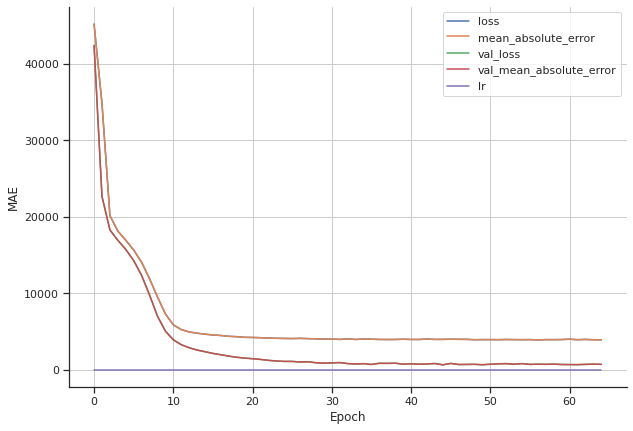

In [38]:
# Plotting training loss over epochs
# Viewing training history
fig, ax = plt.subplots(figsize=(10,7))
pd.DataFrame(history_1.history).plot(ax = ax)
ax.grid(True)
ax.set_ylabel('MAE');
ax.set_xlabel('Epoch');
plt.savefig('history_1.png', dpi = 600, bbox_inches = 'tight')
plt.show()

In [39]:
# Evaluate model 0 on test data
results_1 = model_1.evaluate(test_dataset_locations)
results_1

15/15 [==============================] - 0s 20ms/step - loss: 674.4646 - mean_absolute_error: 674.4646


[674.464599609375, 674.464599609375]

## Model 2: SMILEs model
An embedding of the SMILES is going to be used on an LSTM and Conv1D layers

### 2.1: Dense model

In [40]:
# Batch and prefetch for optimal performance
BATCH_SIZE = 1024  # 512 molecules evaluated at the same time
train_dataset_smiles = train_dataset_smiles.cache().shuffle(dataset_length).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset_smiles = test_dataset_smiles.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
train_dataset_smiles, test_dataset_smiles

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>)

In [41]:
# Get some insights form the input data before starting with our experiments
for feature, _ in train_dataset_smiles.unbatch().take(1):
  input_shape_smiles = feature.shape
  print(f"Input shape is: {input_shape_smiles} and looks like {feature}.")

Input shape is: (100,) and looks like [-2.1762252   0.38319606 -0.9867322   4.374098    0.12062071 -4.241562
 -0.96939164 -2.90576    -1.0574906  -7.743003    8.230148   -5.867079
  3.277961   -4.543201   -7.0454035  -2.1950605  -0.1988314   0.31819886
 -1.0060825  -1.923193   -5.971287    5.931576   -8.958436   -0.43208927
  5.433376   -3.6164608  -2.735845    3.3012247   5.7957764  -1.4793135
  4.018543   -0.06187306  7.6152315   3.4372222  -2.8508468  -3.0389364
  1.9276438   2.470749   -6.796731   10.271645    1.6139975  -5.5818787
  5.0446415  -2.115215    4.4853196  -5.521287   -2.5669026   5.5852847
  7.2678266   9.15553     0.44475374  4.801935   -2.2618911   0.6070203
  0.86124647  2.8243556  -2.6998856  -1.3434916   2.207344   -3.0322595
  0.35529312 -1.3534062  -0.96379226 -1.3120036  -8.719688   -1.2083019
 -2.3589356   4.9666166  -2.7580242   9.817493   -4.4518976  -2.7471018
  5.764149    2.89274    -5.10093    -0.02414852 -0.0529989  -0.5726769
 -3.0753205  -8.151543    

In [42]:
# Normalization layer for smiles
norm_layer_smiles = tf.keras.layers.Normalization(name = 'normalization_smiles')
norm_layer_smiles.adapt(data = train_dataset_smiles.map(
    map_func = lambda features, energy: features,
    num_parallel_calls = tf.data.AUTOTUNE
))

In [43]:
# Getting input shape and testing normalization layer

for feature, _ in train_dataset_smiles.unbatch().take(1):
  input_shape_smiles = feature.shape
  normalized = norm_layer_smiles(feature)
  print(f"Model input shape is: {input_shape_smiles} and looks like {feature}.")
  print(f"After normalization, input data looks like {normalized}")

Model input shape is: (100,) and looks like [ -6.4499016    6.6241746   -8.80722     -1.0155811   -3.430251
  -8.310886     7.645656    -4.5273314  -10.450669   -22.739058
  19.423355   -27.871923     9.935548   -17.270096    -8.231418
  12.112366    -5.243066    13.804553    -1.084384   -13.728955
 -24.722038    15.134026    -7.659217   -10.046686    11.034551
  16.738754    10.493548    -0.30526495  19.097115    -2.3278847
  10.124147    -0.3301823   18.856789    13.329405    -6.3148746
  -7.4589972    1.3353057    5.161347   -11.68364     15.90471
   2.826651   -25.556263    21.755072     1.766782    -7.94803
 -21.643288   -15.100478    26.3372      21.970787    22.905535
  -7.853269    -0.63701004 -22.84226      6.7110925   10.148194
   0.65214753  -9.161876   -25.774061    12.41146     16.50441
   9.980652    -6.2436223    5.48829      7.4446654  -28.314499
  -0.77558494  -3.2864115   19.415733   -19.402956    13.789219
  -4.0412493   -2.854315    15.0810995   14.386215    -3.3035

In [44]:
# Building model 2
inputs = tf.keras.layers.Input(shape = input_shape_smiles, name = "input_layer")
#x = norm_layer_molecules(inputs)
x = tf.keras.layers.Dense(units = 128)(inputs)
output = tf.keras.layers.Dense(units = 1,
                              name = 'output_layer')(x)
model_2 = tf.keras.Model(inputs = inputs,
                         outputs = output,
                         name = 'model_2')

In [45]:
model_2.compile(loss = tf.keras.losses.mae,
                optimizer = tf.keras.optimizers.Adam(),
                metrics = tf.keras.metrics.mae)

In [46]:
model_2.summary(show_trainable = True)

Model: "model_2"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_layer (InputLayer)    [(None, 100)]             0         Y          
                                                                            
 dense_2 (Dense)             (None, 128)               12928     Y          
                                                                            
 output_layer (Dense)        (None, 1)                 129       Y          
                                                                            
Total params: 13,057
Trainable params: 13,057
Non-trainable params: 0
____________________________________________________________________________


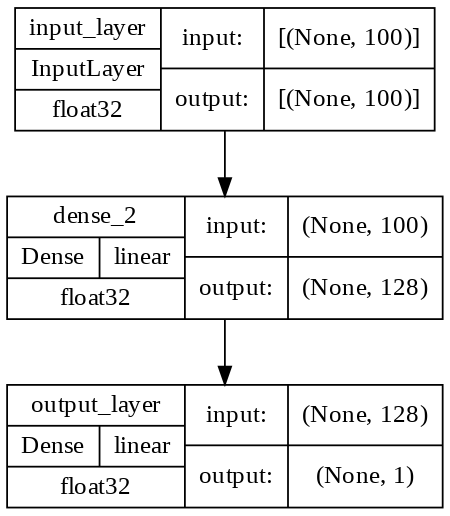

In [47]:
# Plot model 2
plot_model(model_2,
           to_file="model2.png",
           show_shapes = True,
           show_dtype = True,
           dpi = 128,
           show_layer_activations = True
           )

In [48]:
# Fit the model
history_2 = model_2.fit(train_dataset_smiles,
            epochs = 5000,
            validation_data = test_dataset_smiles,
            callbacks = [tf.keras.callbacks.EarlyStopping(
                patience = 40,
                monitor = 'val_loss',
                restore_best_weights = True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                patience = 10,
                monitor = 'val_loss',
                verbose = 1
            )])

Epoch 1/5000
43/43 [==============================] - 1s 5ms/step - loss: 45687.5000 - mean_absolute_error: 45687.5000 - val_loss: 44695.7461 - val_mean_absolute_error: 44695.7461 - lr: 0.0010
Epoch 2/5000
43/43 [==============================] - 0s 3ms/step - loss: 43926.1289 - mean_absolute_error: 43926.1289 - val_loss: 42237.5117 - val_mean_absolute_error: 42237.5117 - lr: 0.0010
Epoch 3/5000
43/43 [==============================] - 0s 3ms/step - loss: 40694.6953 - mean_absolute_error: 40694.6953 - val_loss: 38134.6016 - val_mean_absolute_error: 38134.6016 - lr: 0.0010
Epoch 4/5000
43/43 [==============================] - 0s 3ms/step - loss: 35754.8281 - mean_absolute_error: 35754.8281 - val_loss: 32276.0977 - val_mean_absolute_error: 32276.0977 - lr: 0.0010
Epoch 5/5000
43/43 [==============================] - 0s 3ms/step - loss: 29153.6230 - mean_absolute_error: 29153.6230 - val_loss: 25144.4883 - val_mean_absolute_error: 25144.4883 - lr: 0.0010
Epoch 6/5000
43/43 [===============

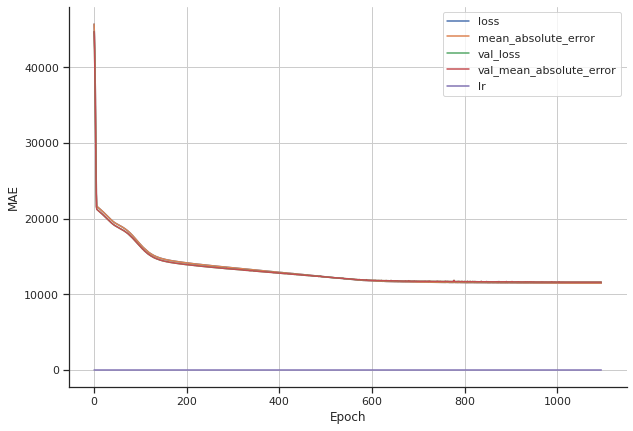

In [49]:
# Viewing training history
fig, ax = plt.subplots(figsize=(10,7))
pd.DataFrame(history_2.history).plot(ax = ax)
ax.grid(True)
ax.set_ylabel('MAE');
ax.set_xlabel('Epoch');
plt.savefig('history_2.png', dpi = 600, bbox_inches = 'tight')
plt.show()

In [50]:
# Evaluate model 2 on test data
results_2 = model_2.evaluate(test_dataset_smiles)
results_2

15/15 [==============================] - 0s 2ms/step - loss: 11606.8164 - mean_absolute_error: 11606.8164


[11606.81640625, 11606.81640625]

### 2.2: CNN 1D model
They expect an input shape of (batch_size, input_dim, 1)

In [51]:
# Building model 3
inputs = tf.keras.layers.Input(shape = input_shape_smiles, name = "input_layer")
#x = norm_layer_molecules(inputs)
x = expand_dims()(inputs)
x = tf.keras.layers.Conv1D(filters = 32, kernel_size = 3, activation='relu')(x)
x = tf.keras.layers.GlobalMaxPool1D()(x)
x = tf.keras.layers.Dropout(0.25, name = 'first_dropout')(x)
x = tf.keras.layers.Dense(units = 128)(x)
x = tf.keras.layers.Dropout(0.5, name = 'second_dropout')(x)
output = tf.keras.layers.Dense(units = 1,
                              name = 'output_layer')(x)
model_3 = tf.keras.Model(inputs = inputs,
                         outputs = output,
                         name = 'model_3')

input_shape to expand_dims layer is (None, 100)


In [52]:
model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 100)]             0         
                                                                 
 expand_dims_2 (expand_dims)  (None, 100, 1)           0         
                                                                 
 conv1d (Conv1D)             (None, 98, 32)            128       
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 first_dropout (Dropout)     (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 128)               4224      
                                                           

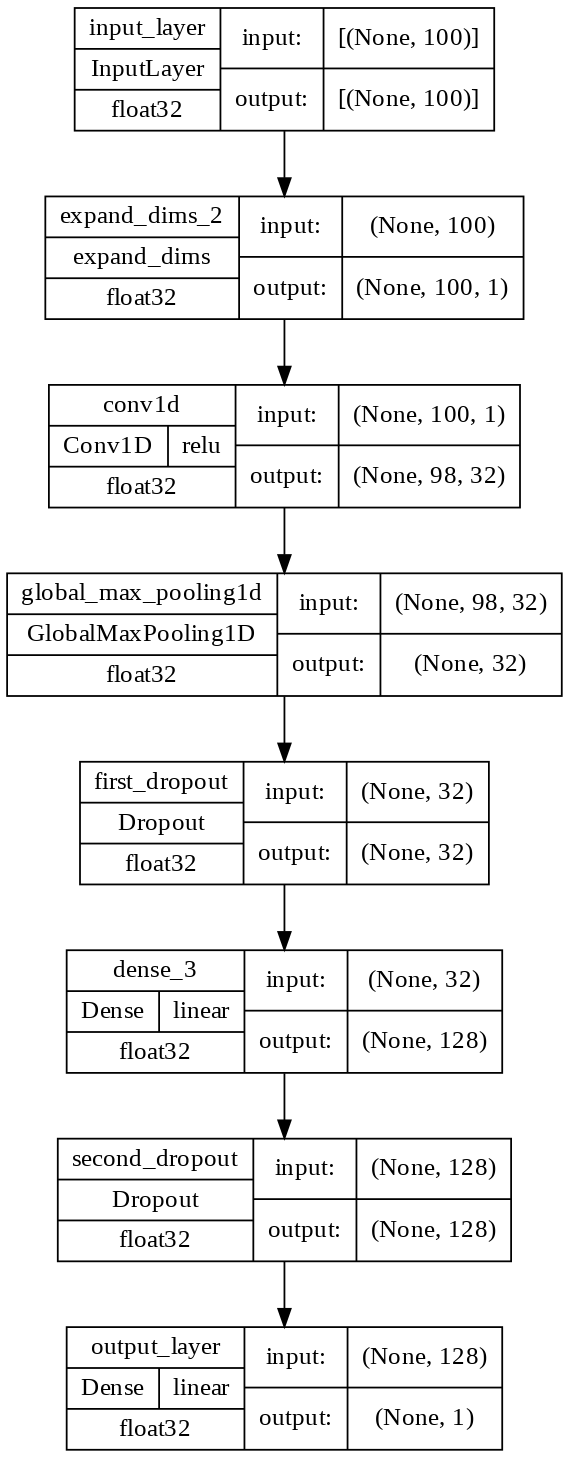

In [53]:
# Plot model 3
plot_model(model_3,
           to_file="model3.png",
           show_shapes = True,
           show_dtype = True,
           dpi = 128,
           show_layer_activations = True
           )

In [54]:
model_3.compile(loss = tf.keras.losses.mae,
                optimizer = tf.keras.optimizers.Adam(),
                metrics = tf.keras.metrics.mae)

In [55]:
# Fit the model
history_3 = model_3.fit(train_dataset_smiles,
            epochs = 5000,
            validation_data = test_dataset_smiles,
            callbacks = [tf.keras.callbacks.EarlyStopping(
                patience = 40,
                monitor = 'val_loss',
                restore_best_weights = True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                patience = 10,
                monitor = 'val_loss',
                verbose = 1
            )])

Epoch 1/5000
43/43 [==============================] - 1s 7ms/step - loss: 46071.9297 - mean_absolute_error: 46071.9297 - val_loss: 45561.8047 - val_mean_absolute_error: 45561.8047 - lr: 0.0010
Epoch 2/5000
43/43 [==============================] - 0s 4ms/step - loss: 45370.7305 - mean_absolute_error: 45370.7305 - val_loss: 44323.6602 - val_mean_absolute_error: 44323.6602 - lr: 0.0010
Epoch 3/5000
43/43 [==============================] - 0s 4ms/step - loss: 43256.6016 - mean_absolute_error: 43256.6016 - val_loss: 41066.4648 - val_mean_absolute_error: 41066.4648 - lr: 0.0010
Epoch 4/5000
43/43 [==============================] - 0s 4ms/step - loss: 38495.1055 - mean_absolute_error: 38495.1055 - val_loss: 34472.8633 - val_mean_absolute_error: 34472.8633 - lr: 0.0010
Epoch 5/5000
43/43 [==============================] - 0s 4ms/step - loss: 30014.8125 - mean_absolute_error: 30014.8125 - val_loss: 24251.5781 - val_mean_absolute_error: 24251.5781 - lr: 0.0010
Epoch 6/5000
43/43 [===============

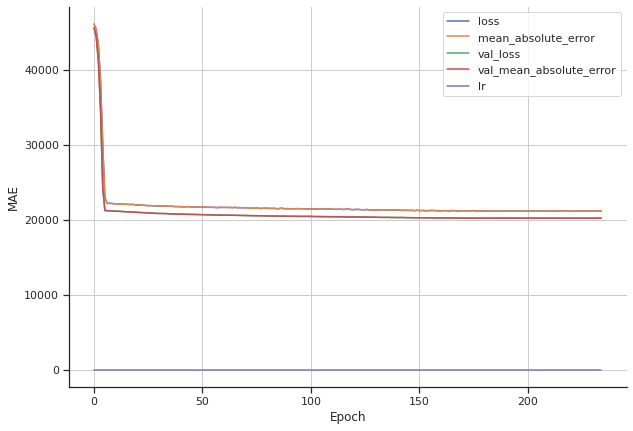

In [56]:
# Viewing training history
fig, ax = plt.subplots(figsize=(10,7))
pd.DataFrame(history_3.history).plot(ax = ax)
ax.grid(True)
ax.set_ylabel('MAE');
ax.set_xlabel('Epoch');
plt.savefig('history_3.png', dpi = 600, bbox_inches = 'tight')
plt.show()

In [57]:
# Evaluate model 0 on test data
results_3 = model_3.evaluate(test_dataset_smiles)
results_3

15/15 [==============================] - 0s 2ms/step - loss: 20218.5254 - mean_absolute_error: 20218.5254


[20218.525390625, 20218.525390625]

## Model 3: Ensemble model
The three best performing models are going to be used to make a common prediction on the energy level

In [58]:
# Model 0
inputs_0 = tf.keras.layers.Input(shape = input_shape, name = "input_layer_molecule")
normalized_molecules = norm_layer_molecules(inputs_0)
dense_molecules = tf.keras.layers.Dense(units = 128)(normalized_molecules)
#output_molecules = tf.keras.layers.Dense(units = 1,
                             # name = 'output_layer')(dense_molecules)
model_0_en = tf.keras.Model(inputs = inputs_0,
                         outputs = dense_molecules)

# Model 1
inputs_1 = tf.keras.layers.Input(shape = input_shape_coulomb, name = "input_layer_positions")
expanded_positions = expand_dims()(inputs_1)
normalized_positions = norm_layer_coulomb(expanded_positions)
conv_1_positions = tf.keras.layers.Conv2D(filters = 32,
                           kernel_size = 3,
                           activation = 'relu',
                           name = 'convolutional_1')(normalized_positions)
pooled_1_positions = tf.keras.layers.MaxPool2D(name = 'max_pool_1')(conv_1_positions)
dropped_1_positions = tf.keras.layers.Dropout(0.25, name = 'first_dropout_positions')(pooled_1_positions)
flatten_positions = tf.keras.layers.Flatten(name = 'flatten_layer_positions')(dropped_1_positions)
dense_1_positions = tf.keras.layers.Dense(units = 128)(flatten_positions)
#dropped_2_positions = tf.keras.layers.Dropout(0.5, name = 'second_dropout')(dense_1_positions)
#output_positions = tf.keras.layers.Dense(units = 1,
                              # name = 'output_layer')(dropped_2_positions)
model_1_en = tf.keras.Model(inputs = inputs_1,
                         outputs = dense_1_positions)

# Model 2
inputs_2 = tf.keras.layers.Input(shape = input_shape_smiles, name = "input_layer_smiles")
#x = norm_layer_molecules(inputs)
expanded_smiles = expand_dims()(inputs_2)
conv_1_smiles = tf.keras.layers.Conv1D(filters = 32, kernel_size = 3, activation='relu')(expanded_smiles)
pooled_1_smiles = tf.keras.layers.GlobalMaxPool1D()(conv_1_smiles)
dropped_1_smiles = tf.keras.layers.Dropout(0.25, name = 'first_dropout_smiles')(pooled_1_smiles)
dense_1_smiles = tf.keras.layers.Dense(units = 128)(dropped_1_smiles)
#dropped_2_smiles = tf.keras.layers.Dropout(0.5, name = 'second_dropout')(dense_1_smiles)
#output_smiles = tf.keras.layers.Dense(units = 1,
                              #name = 'output_layer')(dropped_2_smiles)
model_3_en = tf.keras.Model(inputs = inputs_2,
                         outputs = dense_1_smiles)

# Concatenate layer
molecules_concat = tf.keras.layers.Concatenate(name="molecule")([model_0_en.output, 
                                                                  model_1_en.output,
                                                                 model_3_en.output])

# Output layers
dropped_1_combined = tf.keras.layers.Dropout(0.5)(molecules_concat)
combined_dense = tf.keras.layers.Dense(128)(dropped_1_combined)
dropped_2_combined = tf.keras.layers.Dropout(0.5)(combined_dense)
output = tf.keras.layers.Dense(1)(dropped_2_combined)

# Model 4
model_4 = tf.keras.Model(inputs=[model_0_en.input, model_1_en.input, model_3_en.input],
                         outputs=output,
                         name='molecules_ensemble')

input_shape to expand_dims layer is (None, 77, 77)
input_shape to expand_dims layer is (None, 100)


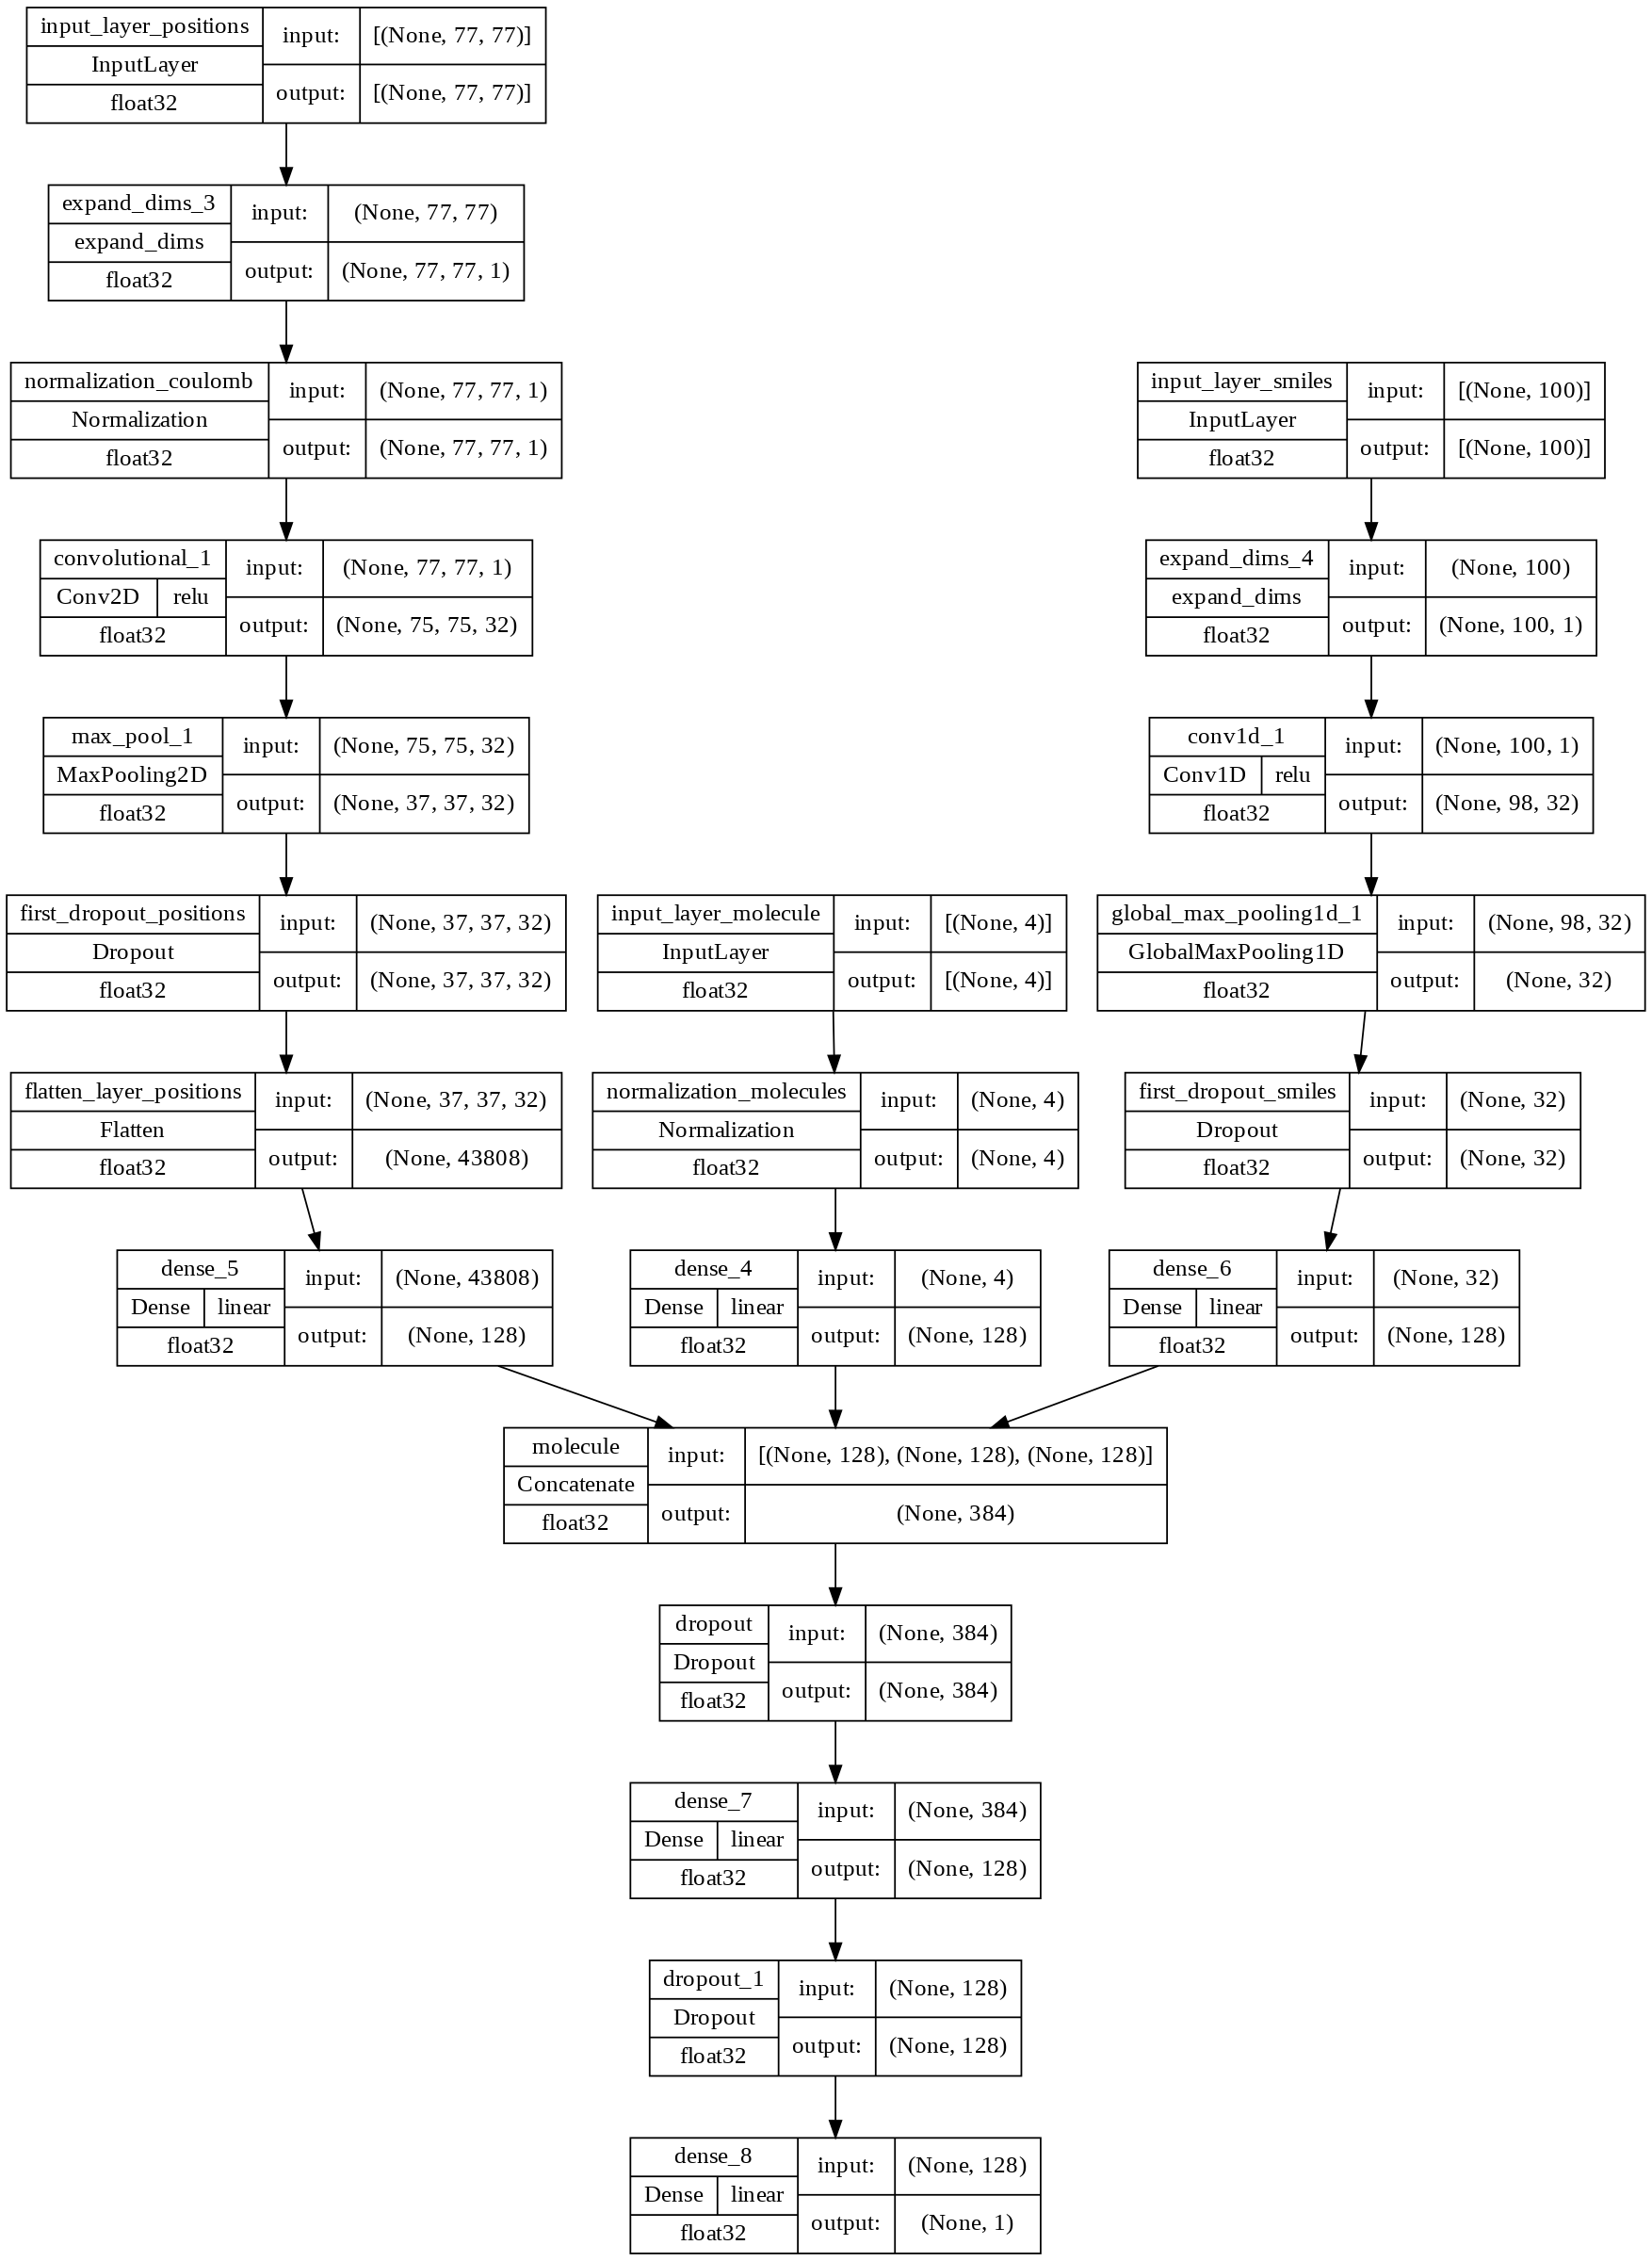

In [59]:
# Plot model 4
plot_model(model_4,
           to_file="model4.png",
           show_shapes = True,
           show_dtype = True,
           dpi = 128,
           show_layer_activations = True
           )

In [60]:
# Compiling the model
model_4.compile(loss = tf.keras.losses.mae,
                optimizer = tf.keras.optimizers.Adam(),
                metrics = tf.keras.metrics.mae)

In [61]:
model_4.summary()

Model: "molecules_ensemble"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer_positions (InputLa  [(None, 77, 77)]    0           []                               
 yer)                                                                                             
                                                                                                  
 expand_dims_3 (expand_dims)    (None, 77, 77, 1)    0           ['input_layer_positions[0][0]']  
                                                                                                  
 normalization_coulomb (Normali  (None, 77, 77, 1)   3           ['expand_dims_3[0][0]']          
 zation)                                                                                          
                                                                                 

In [62]:
# Now we need to create our input data. Order is given by the model 
with np.load(data_path, allow_pickle = True) as data:
  X_train_ensemble = tf.data.Dataset.from_tensor_slices((data['X_train'][:, 1:5].astype(np.float32), data['X_train'][:, 0].tolist(), data['X_train'][:, -1].tolist()))
  X_test_ensemble = tf.data.Dataset.from_tensor_slices((data['X_test'][:, 1:5].astype(np.float32), data['X_test'][:, 0].tolist(), data['X_test'][:, -1].tolist()))

train_dataset_ensemble = tf.data.Dataset.zip((X_train_ensemble, y_train))
test_dataset_ensemble = tf.data.Dataset.zip((X_test_ensemble, y_test))

In [63]:
# Batching, caching and prefetching
BATCH_SIZE = 1024

train_dataset_ensemble = train_dataset_ensemble.cache().shuffle(dataset_length).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset_ensemble = test_dataset_ensemble.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
train_dataset_ensemble, test_dataset_ensemble

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 77, 77), dtype=tf.float64, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 77, 77), dtype=tf.float64, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>)

In [64]:
# Fit the model
history_4 = model_4.fit(train_dataset_ensemble,
            epochs = 5000,
            validation_data = test_dataset_ensemble,
            callbacks = [tf.keras.callbacks.EarlyStopping(
                patience = 40,
                monitor = 'val_loss',
                restore_best_weights = True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                patience = 10,
                monitor = 'val_loss',
                verbose = 1
            )])

Epoch 1/5000
43/43 [==============================] - 3s 45ms/step - loss: 40252.2891 - mean_absolute_error: 40252.2891 - val_loss: 20037.7324 - val_mean_absolute_error: 20037.7324 - lr: 0.0010
Epoch 2/5000
43/43 [==============================] - 2s 39ms/step - loss: 19006.2305 - mean_absolute_error: 19006.2305 - val_loss: 16452.3105 - val_mean_absolute_error: 16452.3105 - lr: 0.0010
Epoch 3/5000
43/43 [==============================] - 2s 39ms/step - loss: 15628.7598 - mean_absolute_error: 15628.7598 - val_loss: 12256.8857 - val_mean_absolute_error: 12256.8857 - lr: 0.0010
Epoch 4/5000
43/43 [==============================] - 2s 39ms/step - loss: 10199.9990 - mean_absolute_error: 10199.9990 - val_loss: 4553.6616 - val_mean_absolute_error: 4553.6616 - lr: 0.0010
Epoch 5/5000
43/43 [==============================] - 2s 39ms/step - loss: 6166.8960 - mean_absolute_error: 6166.8960 - val_loss: 2856.5061 - val_mean_absolute_error: 2856.5061 - lr: 0.0010
Epoch 6/5000
43/43 [================

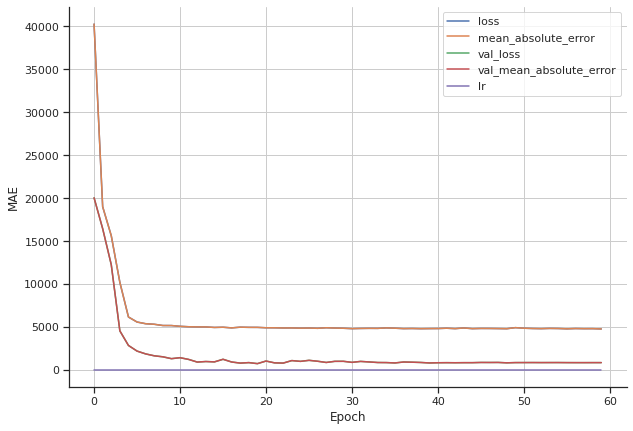

In [84]:
# Viewing training history
fig, ax = plt.subplots(figsize=(10,7))
pd.DataFrame(history_4.history).plot(ax = ax)
ax.grid(True)
ax.set_ylabel('MAE');
ax.set_xlabel('Epoch');
plt.savefig('history_4.png', dpi = 600, bbox_inches = 'tight')
plt.show()

In [66]:
# Evaluate model 2 on test data
results_4 = model_4.evaluate(test_dataset_ensemble)
results_4

15/15 [==============================] - 0s 20ms/step - loss: 741.1913 - mean_absolute_error: 741.1913


[741.1912841796875, 741.1912841796875]

# Step 3: Evaluate the models

In [74]:
results_dict = {
    'molecular' : results_0[-1],
    'positional' : results_1[-1],
    'smiles_dense' : results_2[-1],
    'smiles_conv1D' : results_3[-1],
    'ensemble': results_4[-1]
}

model_results = pd.DataFrame(results_dict, index = ['mae']).T
model_results

,mae
molecular,9025.474609
positional,674.464600
smiles_dense,11606.816406
smiles_conv1D,20218.525391
ensemble,741.191284


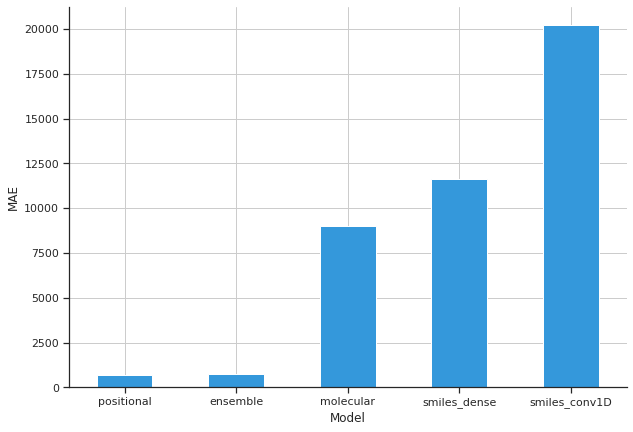

In [83]:
# Viewing training history
fig, ax = plt.subplots(figsize=(10,7))
model_results[["mae"]].sort_values(by="mae").plot(ax = ax, kind="bar", color = '#3498DB');
ax.grid(True)
ax.set_ylabel('MAE');
ax.set_xlabel('Model');
plt.xticks(rotation = 0);
ax.get_legend().remove();
plt.savefig('model_results.png', dpi = 600, bbox_inches = 'tight')
plt.show()